In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [17]:
# Load the CSV files
users_path = "cleaned_users.csv"  # Replace with actual file path
transactions_path = "cleaned_transactions.csv"  # Replace with actual file path
products_path = "cleaned_products.csv"  # Replace with actual file path

In [18]:
# Load and process data
users = pd.read_csv(users_path)
transactions = pd.read_csv(transactions_path)
products = pd.read_csv(products_path)

In [19]:
print(users.head(3))
print(transactions.head(3))
print(products.head())

                         ID         CREATED_DATE           BIRTH_DATE STATE  \
0  5ef3b4f17053ab141787697d  2020-06-24 20:17:54  2000-08-11 00:00:00    CA   
1  5ff220d383fcfc12622b96bc  2021-01-03 19:53:55  2001-09-24 04:00:00    PA   
2  6477950aa55bb77a0e27ee10  2023-05-31 18:42:18  1994-10-28 00:00:00    FL   

  LANGUAGE  GENDER  
0   es-419  female  
1       en  female  
2   es-419  female  
                             RECEIPT_ID PURCHASE_DATE  \
0  0000d256-4041-4a3e-adc4-5623fb6e0c99    2024-08-21   
1  0001455d-7a92-4a7b-a1d2-c747af1c8fd3    2024-07-20   
2  00017e0a-7851-42fb-bfab-0baa96e23586    2024-08-18   

                 SCAN_DATE STORE_NAME                   USER_ID      BARCODE  \
0  2024-08-21 14:19:06.539    WALMART  63b73a7f3d310dceeabd4758  15300014978   
1  2024-07-20 09:50:24.206       ALDI  62c08877baa38d1a1f6c211a            0   
2  2024-08-19 15:38:56.813    WALMART  60842f207ac8b7729e472020  78742229751   

   FINAL_QUANTITY  FINAL_SALE  
0             1.0

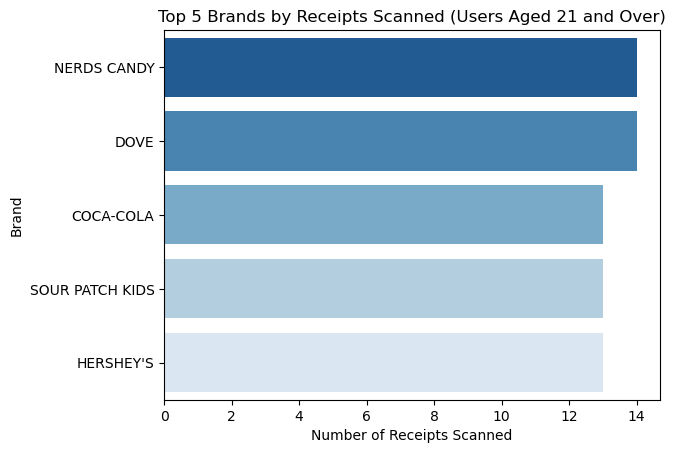

In [20]:
#1.What are the top 5 brands by receipts scanned among users 21 and over?
# Calculate age and filter users 21 and older
users['BIRTH_DATE'] = pd.to_datetime(users['BIRTH_DATE'])
users['age'] = (datetime.now() - users['BIRTH_DATE']).dt.days // 365
adult_users = users[users['age'] >= 21]

# Merge datasets
merged_data = transactions.merge(adult_users, left_on='USER_ID', right_on='ID', how='inner')
merged_data = merged_data.merge(products, on='BARCODE', how='inner')

# Count receipts scanned by brand
receipts_by_brand = merged_data.groupby('BRAND')['RECEIPT_ID'].nunique().reset_index()
receipts_by_brand = receipts_by_brand.rename(columns={'RECEIPT_ID': 'receipts_count'})

# Find top 5 brands
top_5_brands = receipts_by_brand.sort_values('receipts_count', ascending=False).head(5)

# Visualization
sns.barplot(data=top_5_brands, x='receipts_count', y='BRAND', palette='Blues_r')
plt.title('Top 5 Brands by Receipts Scanned (Users Aged 21 and Over)')
plt.xlabel('Number of Receipts Scanned')
plt.ylabel('Brand')
plt.show()

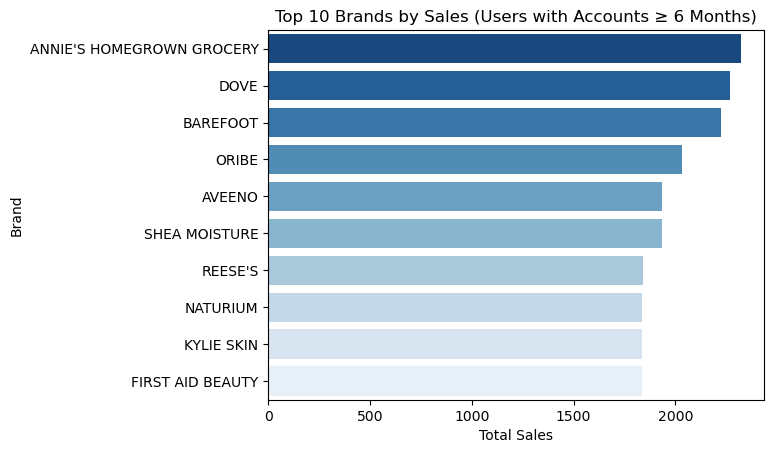

In [21]:
#2. Top 10 Brands by Sales Among Users with Accounts for At Least Six Months
# Process datetime columns
users['CREATED_DATE'] = pd.to_datetime(users['CREATED_DATE'])
six_month_cutoff = datetime.now() - pd.DateOffset(months=6)

# Filter users with accounts ≥ 6 months
active_users = users[users['CREATED_DATE'] <= six_month_cutoff]

# Merge datasets
merged_data = transactions.merge(active_users, left_on='USER_ID', right_on='ID', how='inner')
merged_data = merged_data.merge(products, on='BARCODE', how='inner')

# Ensure FINAL_SALE is numeric
merged_data['FINAL_SALE'] = pd.to_numeric(merged_data['FINAL_SALE'], errors='coerce').fillna(0)

# Calculate sales by brand
sales_by_brand = merged_data.groupby('BRAND')['FINAL_SALE'].sum().reset_index()
top_brands = sales_by_brand.sort_values('FINAL_SALE', ascending=False).head(10)

# Visualization
sns.barplot(data=top_brands, x='FINAL_SALE', y='BRAND', palette='Blues_r')
plt.title('Top 10 Brands by Sales (Users with Accounts ≥ 6 Months)')
plt.xlabel('Total Sales')
plt.ylabel('Brand')
plt.show()

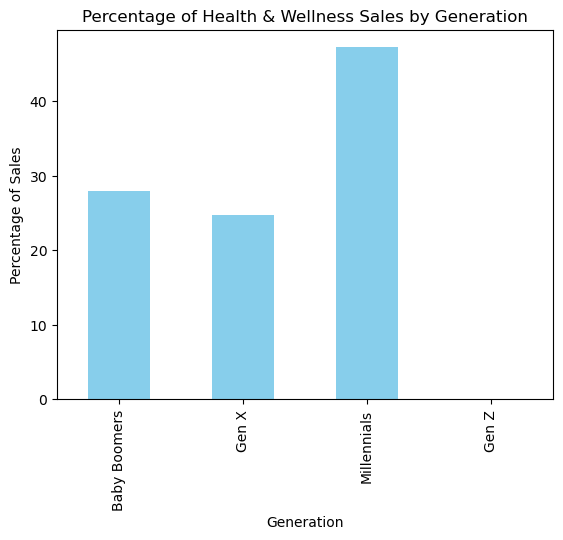

In [22]:
#3. Percentage of Sales in the Health & Wellness Category by Generation
# Add generation column to users
users['BIRTH_DATE'] = pd.to_datetime(users['BIRTH_DATE'])
users['generation'] = pd.cut(
    users['BIRTH_DATE'].dt.year,
    bins=[1900, 1964, 1980, 1996, 2012],
    labels=['Baby Boomers', 'Gen X', 'Millennials', 'Gen Z']
)

# Filter health & wellness transactions
health_transactions = merged_data[merged_data['CATEGORY_1'] == 'Health & Wellness']

# Merge with users to add generation
health_data = health_transactions.merge(users[['ID', 'generation']], left_on='USER_ID', right_on='ID', how='inner')

# Calculate percentage sales by generation
sales_by_generation = health_data.groupby('generation')['FINAL_SALE'].sum()
sales_percentage = (sales_by_generation / sales_by_generation.sum()) * 100

# Visualization
sales_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Health & Wellness Sales by Generation')
plt.ylabel('Percentage of Sales')
plt.xlabel('Generation')
plt.show()

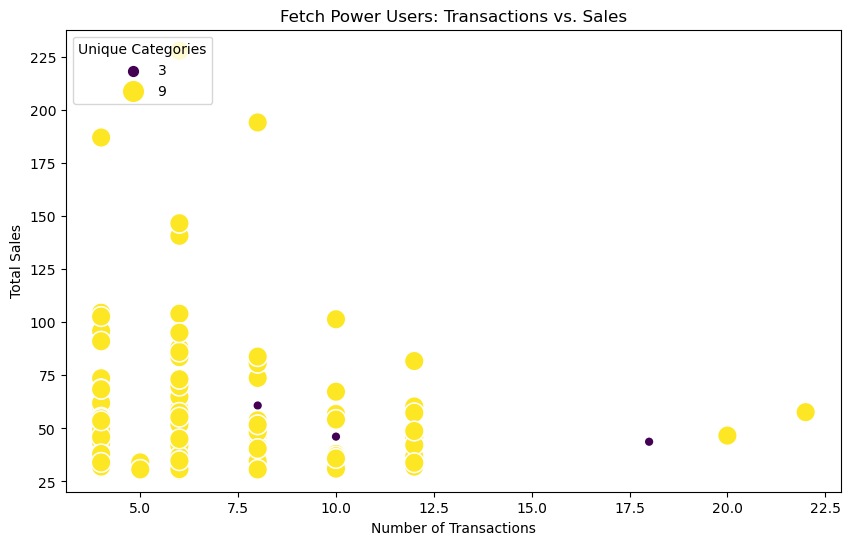

In [25]:
#4.Who are Fetch’s power users?
# Calculate user metrics
user_metrics = transactions.groupby('USER_ID').agg(
    transactions_count=('RECEIPT_ID', 'count'),
    total_sales=('FINAL_SALE', lambda x: pd.to_numeric(x, errors='coerce').sum()),
    unique_categories=('BARCODE', lambda x: products[products['BARCODE'].isin(x)]['CATEGORY_1'].nunique())
).reset_index()

# Define power users
power_users = user_metrics[
    (user_metrics['transactions_count'] > 3) &
    (user_metrics['total_sales'] > 30) &
    (user_metrics['unique_categories'] > 2)
]

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=power_users, x='transactions_count', y='total_sales', size='unique_categories', sizes=(50, 200), hue='unique_categories', palette='viridis')
plt.title('Fetch Power Users: Transactions vs. Sales')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Sales')
plt.legend(title='Unique Categories', loc='upper left')
plt.show()


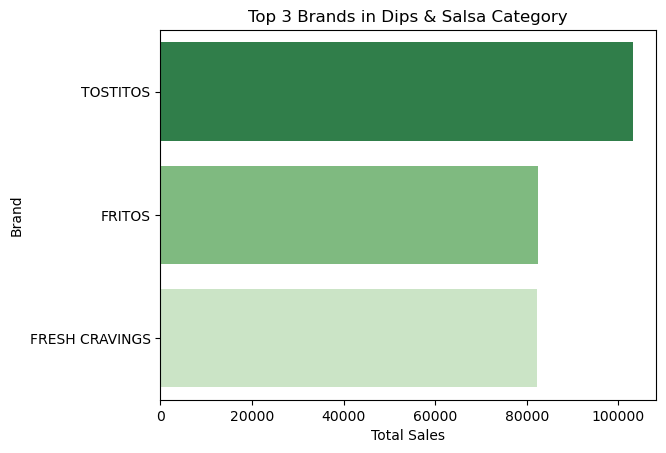

In [24]:
# Ensure FINAL_SALE is numeric
transactions['FINAL_SALE'] = pd.to_numeric(transactions['FINAL_SALE'], errors='coerce').fillna(0)

# Merge transactions and products
merged_data = transactions.merge(products, on='BARCODE', how='inner')

# Filter for Dips & Salsa category
dips_salsa_data = merged_data[merged_data['CATEGORY_2'] == 'Dips & Salsa']

# Aggregate sales by brand
brand_sales = dips_salsa_data.groupby('BRAND')['FINAL_SALE'].sum().reset_index()
top_brands = brand_sales.sort_values('FINAL_SALE', ascending=False).head(3)

# Visualization
sns.barplot(data=top_brands, x='FINAL_SALE', y='BRAND', palette='Greens_r')
plt.title('Top 3 Brands in Dips & Salsa Category')
plt.xlabel('Total Sales')
plt.ylabel('Brand')
plt.show()

In [32]:
#6. At what percent has Fetch grown year over year?-user growth
# Extract year from date columns
users['CREATED_DATE'] = pd.to_datetime(users['CREATED_DATE'])
transactions['PURCHASE_DATE'] = pd.to_datetime(transactions['PURCHASE_DATE'])

# Group users by year of account creation
user_growth = users.groupby(users['CREATED_DATE'].dt.year).size().reset_index(name='new_users')

# Group transactions by year and calculate total sales
sales_growth = transactions.groupby(transactions['PURCHASE_DATE'].dt.year)['FINAL_SALE'].sum().reset_index()

# Ensure FINAL_SALE is numeric
sales_growth['FINAL_SALE'] = pd.to_numeric(sales_growth['FINAL_SALE'], errors='coerce').fillna(0)

# Calculate YoY growth for users
user_growth['YoY_growth'] = user_growth['new_users'].pct_change() * 100

# Calculate YoY growth for sales
sales_growth['YoY_growth'] = sales_growth['FINAL_SALE'].pct_change() * 100

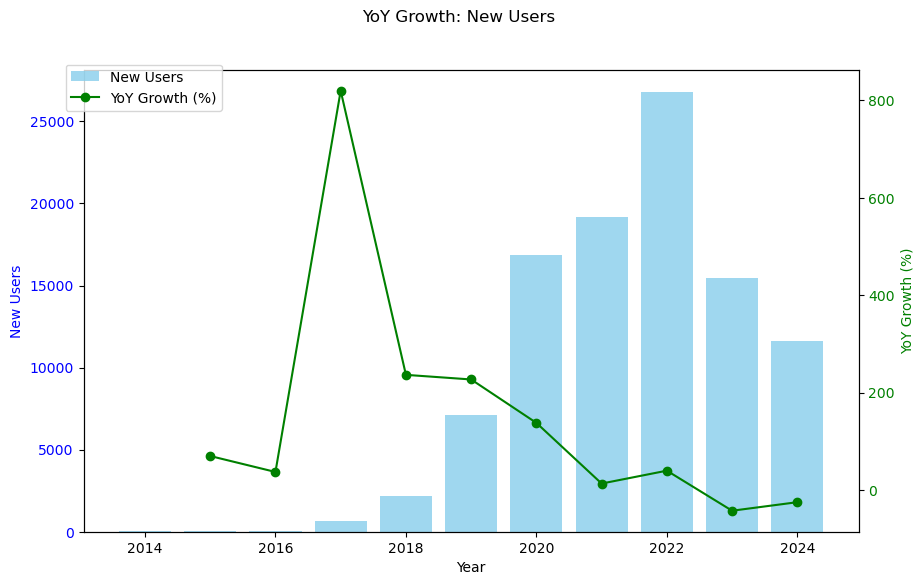

In [33]:
# Visualization: Line Chart with Dual Axes (Users)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total users
ax1.bar(user_growth['CREATED_DATE'], user_growth['new_users'], color='skyblue', alpha=0.8, label='New Users')
ax1.set_xlabel('Year')
ax1.set_ylabel('New Users', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot YoY Growth on secondary axis
ax2 = ax1.twinx()
ax2.plot(user_growth['CREATED_DATE'], user_growth['YoY_growth'], marker='o', color='green', label='YoY Growth (%)')
ax2.set_ylabel('YoY Growth (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

fig.suptitle('YoY Growth: New Users')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()